# Curvature Compression: Baseline Tests

In this notebook, we give a guided tour on the advantage of curvature compression for choosing a linear model for manifold data

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import scipy

from tqdm import trange

from torch.autograd import Variable
# import open3d as o3d

import sys
# setting path
sys.path.append('../')
from tools.manifold_generator import Manifold
# import modules.find_patches_community_detection as find_patches

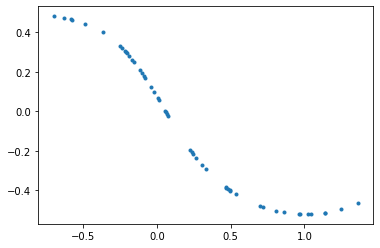

torch.Size([2, 50])


In [56]:
hi = Manifold(D=2, d=1, curvature=1, n_basis=20)
X = hi.generateSample(N=50, uniform=True)
plt.plot(X[0,:], X[1,:],'.')
plt.show()
print(X.shape)

In [54]:
ind, merge_path = find_patches.find_patches_and_merge_path(X, k=5)
print(ind)
print(merge_path)

[{0, 1, 2, 3, 4, 5}, {6, 7, 8, 9, 10, 11}, {16, 17, 12, 13, 14, 15}, {18, 19, 20, 21, 22, 23, 24}]
[[{0}, {1}, {2}, {3}], [{2}, {3}, {0, 1}], [{0, 1}, {2, 3}], [{0, 1, 2, 3}]]


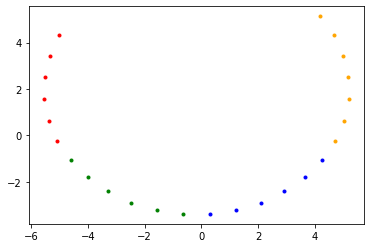

In [55]:
ind1 = np.array([x for x in ind[0]])
plt.plot(X[0,ind1], X[1,ind1], '.', c='r')
ind2 = np.array([x for x in ind[1]])
plt.plot(X[0,ind2], X[1,ind2],'.', c='g')
ind3 = np.array([x for x in ind[2]])
plt.plot(X[0,ind3], X[1,ind3],'.', c='b')
ind4 = np.array([x for x in ind[3]])
plt.plot(X[0,ind4], X[1,ind4],'.', c='orange')
# ind5 = np.array([x for x in ind[4]])
# plt.plot(X[0,ind5], X[1,ind5],'.', c='purple')
plt.show()

In [66]:
hi = Manifold(D=3, d=2, curvature=1, n_basis=20)
X = hi.generateSample(N=50000, uniform=True)

pointclud = X.T.detach().numpy()
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pointclud)
o3d.visualization.draw_geometries([pcd])

# Generate manifold data

In [ ]:
# stochastic gradient descent on MSE error of the training data
# X and the targets Y


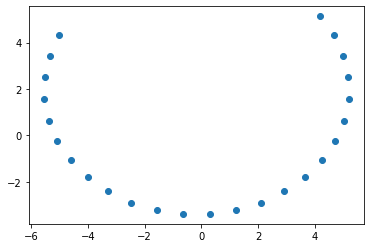

In [51]:
# dimension of data
d = 2
# number of samples
n = 25
# variance of noise
eps2 = 0
# determine if we should randomly rotate
rotate=False


# 2D manifold in 4D space

# sqrt_n = 25
# n = sqrt_n**2

# Z = np.zeros((d,n))
# for i in range(sqrt_n):
# 	for j in range(sqrt_n):
# 		x = (-0.5 + (i+1)/sqrt_n)*2*np.pi
# 		y = (-0.5 + (j+1)/sqrt_n)*2*np.pi
# 		Z[0,j + sqrt_n*i] = x
# 		Z[1,j + sqrt_n*i] = y
# 		Z[2,j + sqrt_n*i] = np.sin(4*x)
# 		Z[3,j + sqrt_n*i] = np.sin(7*y)


# # mean center
# Z = Z - np.mean(Z,axis=1,keepdims=True)
# # global normalization
# Z = Z * n / np.sqrt(np.sum(np.power(Z, 2)))

# plt.scatter(Z[0,:], Z[1,:])
scale=2
Z = np.zeros((d,n))
for i in range(n):
	x = (-0.5 + (i+1)/n)*2*np.pi
	Z[0,i] = x
	# Z[1,i] = scale*np.sin(x)
	Z[1,i] = scale*np.sin(x) + scale/2*np.sin(3*x + 1.5)

Z = np.zeros((d,n))
for i in range(n):
	x = (1.5 - 1.4/2 +1.4*(i+1)/n)*np.pi
	Z[0,i] = np.cos(x)
	# Z[1,i] = scale*np.sin(x)
	Z[1,i] = np.sin(x)

# add noise
Z = Z + eps2*np.random.randn(d, n)


# center and scale
Z_mean_orig = Z.mean(axis=1,keepdims=True)
Z = Z - Z_mean_orig
Z_norm_orig = np.linalg.norm(Z, 'fro')
Z = Z * n / Z_norm_orig

# random rotation, preserves centering and scale
if rotate:
	A = np.random.randn(d,d)
	u,s,vt = np.linalg.svd(A)
	Z = u@Z

# Z = Z[:,8:12]
plt.scatter(Z[0,:], Z[1,:])

# PCA on manifold data

Showing the linear component PCA would choose to eliminate. Note it does not give the proper elimination

[-0.0878512   0.99613361]


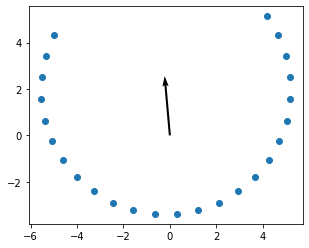

In [5]:
u, s, vt = np.linalg.svd(Z)
u_min = u[:,1]
print(u_min)

# scale to look nice on graph
u_show = u_min * np.min(np.max(np.abs(Z), axis=1))/2

plt.scatter(Z[0,:], Z[1,:])
plt.quiver(0, 0, u_show[0], u_show[1],scale_units='xy', angles='xy',scale=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We would idealy get a vector in the span of $(0,1)$, since all extraneous curvature is in the $y$-direction. As can be seen, the direction of least variance does not necessarily correspond to the best direction to compress curvature.

# Curvature compression on manifold data

We now test our new proposed method, curvature compression. The function we theoretically want to optimize for is the following:

$$v_* = \argmin_{\|v\|_2 = 1} \max_{x, y \in Z \mid x \ne y} |\langle v, \frac{x-y}{\|x-y\|_2}\rangle|$$
$$= \argmin_{\|v\|_2 = 1} \|\langle v, \frac{x-y}{\|x-y\|_2}\rangle\|_\infty. $$

However, since the $L^\infty$ norm is hard to directly optimize, we settle for a smooth surrogate norm: the $L^4$-norm.

In [42]:
# PyTorch model to optimize our custom loss
class CurvatureElimination(nn.Module):

    def __init__(self, X, u_0):
        super(CurvatureElimination, self).__init__();
        # data
        self.X = X
        # construct edm and gamma weight matrix
        gram = X.T@X
        edm = torch.diag(gram).reshape((n,1))@torch.ones((1,n)) \
                + torch.ones((n,1))@torch.diag(gram).reshape((1,n)) \
                - 2*gram

        edm = torch.sqrt(edm)

        # diagonal weights don't matter, set to 1 as convention
        self.gamma = torch.divide(torch.Tensor([1]),torch.eye(n) + edm)
        # projection vec
        self.u = nn.Parameter(u_0)

    def forward(self):
        U_stacked = torch.ones(self.X.shape)*self.u
        A = (self.X.T @ U_stacked - U_stacked.T @ self.X)*self.gamma
        return 0.5*A.pow(4).sum()

# PyTorch model to optimize our custom loss
class CurvatureEliminationSGD(nn.Module):

    def __init__(self, u_0):
        super(CurvatureEliminationSGD, self).__init__();

        # projection vec
        self.u = nn.Parameter(u_0)

    def forward(self, X_batch):
        # compute injectivity loss on minibatch
        d, n_batch = X_batch.shape
        edm_batch = torch.cdist(X_batch.T, X_batch.T)
        gamma_batch = torch.divide(torch.Tensor([1]),torch.eye(n_batch) + edm_batch)
        U_stacked = torch.ones(X_batch.shape)*self.u
        A = (X_batch.T @ U_stacked - U_stacked.T @ X_batch)*gamma_batch
        return 0.5*A.pow(4).mean()

# PyTorch model to optimize our custom loss
class CurvatureEliminationPieces(nn.Module):

    def __init__(self, X, u_0, u_02, u_03):
        super(CurvatureEliminationPieces, self).__init__();
        # data
        self.X = X
        # construct edm and gamma weight matrix
        gram = X.T@X
        edm = torch.diag(gram).reshape((n,1))@torch.ones((1,n)) \
                + torch.ones((n,1))@torch.diag(gram).reshape((1,n)) \
                - 2*gram

        edm = torch.sqrt(edm)

        # diagonal weights don't matter, set to 1 as convention
        self.gamma = torch.divide(torch.Tensor([1]),torch.eye(n) + edm)
        # projection vec
        self.u = nn.Parameter(u_0)
        self.u2 = nn.Parameter(u_02)
        self.u3 = nn.Parameter(u_03)

    def forward(self):
        U_stacked = torch.ones(self.X[:,:13].shape)*self.u
        A = (self.X[:,:13].T @ U_stacked - U_stacked.T @ self.X[:,:13])*self.gamma[:13,:13]
        U_stacked2 = torch.ones(self.X[:,7:16].shape)*self.u2
        A2 = (self.X[:,7:16].T @ U_stacked2 - U_stacked2.T @ self.X[:,7:16])*self.gamma[7:16,7:16]
        U_stacked3 = torch.ones(self.X[:,13:].shape)*self.u3
        A3 = (self.X[:,13:].T @ U_stacked3 - U_stacked3.T @ self.X[:,13:])*self.gamma[13:,13:]
        return 0.5*(A.pow(4).sum() + A2.pow(4).sum() + A3.pow(4).sum()) - 2*((self.u.T@self.u2).pow(2) + (self.u2.T@self.u3).pow(2))

In [20]:
loader = data.DataLoader(dataset=data.TensorDataset(X.T), batch_size=12, shuffle=True)
# sample batch from loader
X_batch = next(iter(loader))[0].T
print(X.shape)
print(X_batch.shape)

torch.Size([2, 500])
torch.Size([2, 12])


# SGD tests

In [54]:
d, n = X.shape
batch_size =10
u_0 = torch.randn(d,1)
u_0 = u_0 / torch.norm(u_0, p=2, dim=0)

cc = CurvatureEliminationSGD(u_0)
loader = data.DataLoader(dataset=data.TensorDataset(X.T), batch_size=12, shuffle=True)

opt = optim.SGD(cc.parameters(), lr=0.01)

for i in range(10000):
	cc.zero_grad()
	# forward call of LinFlow
	X_batch = next(iter(loader))[0].T
	loss = cc(X_batch)

	loss.backward()

	# compute Riemannian gradient
	egrad = cc.u.grad.detach()
	base = cc.u.data.detach()
	base = base / torch.sqrt(base.pow(2).sum())
	rgrad = egrad - base@base.t()@egrad
	# GD step
	opt.step()
	# renormalization step
	with torch.no_grad():
		cc.u.data = cc.u.data / torch.sqrt((cc.u.data).pow(2).sum());

	# determine if we have converged
	gradnorm = torch.linalg.norm(rgrad)
	if gradnorm < 5e-5:
		# print(f'converged in {i} steps!')
		# break
		pass
	if i%100 == 0:
		print(f'g step {i}: {gradnorm}')

print('done!')

g step 0: 0.016552096232771873
g step 100: 0.03008676879107952
g step 200: 0.046776991337537766
g step 300: 0.05334431305527687
g step 400: 0.057042889297008514
g step 500: 0.021112091839313507
g step 600: 0.03477724269032478
g step 700: 0.010997059755027294
g step 800: 0.0019211889011785388
g step 900: 0.005317394621670246
g step 1000: 0.0026451428420841694
g step 1100: 0.003939591348171234
g step 1200: 0.006208642385900021
g step 1300: 0.0070342449471354485
g step 1400: 0.005849484819918871
g step 1500: 0.02514476887881756
g step 1600: 0.0040291426703333855
g step 1700: 0.0015502816531807184
g step 1800: 0.011169602163136005
g step 1900: 0.0013696800451725721
g step 2000: 0.010322331450879574
g step 2100: 0.006969420239329338
g step 2200: 0.0058410814963281155
g step 2300: 0.00986667349934578
g step 2400: 0.0031435585115104914
g step 2500: 0.0014721740735694766
g step 2600: 0.012260540388524532
g step 2700: 0.0024457862600684166
g step 2800: 0.016621556133031845
g step 2900: 0.031186

In [24]:
# optimize via projected gradient descent

u_0 = torch.randn((d,1))
u_0 = u_0 / torch.sqrt(u_0.pow(2).sum())
u_02 = torch.randn((d,1))
u_02 = u_02 / torch.sqrt(u_02.pow(2).sum())
u_03 = torch.randn((d,1))
u_03 = u_03 / torch.sqrt(u_03.pow(2).sum())
X = torch.Tensor(Z)

cc = CurvatureEliminationPieces(X, u_0, u_02, u_03)
opt = optim.SGD(cc.parameters(), lr=0.001)

for i in range(1000):
	cc.zero_grad()
	# forward call of LinFlow
	loss = cc()

	loss.backward()

	# compute Riemannian gradient
	egrad = cc.u.grad.detach()
	base = cc.u.data.detach()
	base = base / torch.sqrt(base.pow(2).sum())
	rgrad = egrad - base@base.t()@egrad
	# GD step
	opt.step()
	# renormalization step
	with torch.no_grad():
		cc.u.data = cc.u.data / torch.sqrt((cc.u.data).pow(2).sum());
		cc.u2.data = cc.u2.data / torch.sqrt((cc.u2.data).pow(2).sum());
		cc.u3.data = cc.u3.data / torch.sqrt((cc.u3.data).pow(2).sum());

	# determine if we have converged
	gradnorm = torch.linalg.norm(rgrad)
	if gradnorm < 5e-5:
		# print(f'converged in {i} steps!')
		# break
		pass
	if i%100 == 0:
		print(f'g step {i}: {gradnorm}')

print('done!')

NameError: name 'Z' is not defined

In [53]:
# optimize via projected gradient descent

u_0 = torch.randn((d,1))
u_0 = u_0 / torch.sqrt(u_0.pow(2).sum())
X = torch.Tensor(Z)

cc = CurvatureEliminationPieces(X, u_0, u_02, u_03)
opt = optim.SGD(cc.parameters(), lr=0.001)

for i in range(1000):
	cc.zero_grad()
	# forward call of LinFlow
	loss = cc()

	loss.backward()

	# compute Riemannian gradient
	egrad = cc.u.grad.detach()
	base = cc.u.data.detach()
	base = base / torch.sqrt(base.pow(2).sum())
	rgrad = egrad - base@base.t()@egrad
	# GD step
	opt.step()
	# renormalization step
	with torch.no_grad():
		cc.u.data = cc.u.data / torch.sqrt((cc.u.data).pow(2).sum());
		cc.u2.data = cc.u2.data / torch.sqrt((cc.u2.data).pow(2).sum());
		cc.u3.data = cc.u3.data / torch.sqrt((cc.u3.data).pow(2).sum());

	# determine if we have converged
	gradnorm = torch.linalg.norm(rgrad)
	if gradnorm < 5e-5:
		# print(f'converged in {i} steps!')
		# break
		pass
	if i%100 == 0:
		print(f'g step {i}: {gradnorm}')

print('done!')

g step 0: 48.64806365966797
g step 100: 0.010759027674794197
g step 200: 0.00017109086911659688
g step 300: 2.117500662279781e-05
g step 400: 2.5177723728120327e-05
g step 500: 3.43852161677205e-06
g step 600: 3.43852161677205e-06
g step 700: 3.43852161677205e-06
g step 800: 3.43852161677205e-06
g step 900: 3.43852161677205e-06
done!


learned compression direction: [[ 0.04923584 -0.9987872 ]]


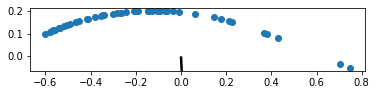

In [55]:
# show learned compression direction
u_cc = cc.u.data.detach().clone().numpy()

print(f'learned compression direction: {u_cc.T}')
# scale to look nice on graph
# u_show = u_cc * np.min(np.max(torch.abs(X), axis=1))/2
u_show = u_cc

plt.scatter(X[0,:], X[1,:])
# plt.scatter(Z[0,3], Z[1,3],c='r')
# plt.scatter(Z[0,11], Z[1,11],c='r')
# plt.scatter(Z[0,18], Z[1,18],c='r')
plt.quiver(0, 0, u_show[0], u_show[1],scale_units='xy', angles='xy',scale=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [32]:
maxval = 0
for i in range(8):
	for j in range(8):
		if i != j:
			if np.abs(u_cc.T@(Z[:,i]-Z[:,j]) / np.linalg.norm(Z[:,i]-Z[:,j]))  > maxval:
				maxval = u_cc.T@(Z[:,i]-Z[:,j])/ np.linalg.norm(Z[:,i]-Z[:,j])
		

print(f'max correlation from computed vec:{maxval}')

u_new = np.zeros((2,1))
u_new[1] = 1
u_new[0] = 0
u_new = u_new / np.linalg.norm(u_new)
maxval = 0
for i in range(8):
	for j in range(8):
		if i != j:
			if np.abs(u_new.T@(Z[:,i]-Z[:,j])/ np.linalg.norm(Z[:,i]-Z[:,j])) > maxval:
				maxval = u_new.T@(Z[:,i]-Z[:,j])/ np.linalg.norm(Z[:,i]-Z[:,j])
		

print(f'max correlation from (0,1):{maxval}')

U_stacked = np.ones(Z.shape)*u_cc
A = (Z.T @ U_stacked - U_stacked.T @ Z)*cc.gamma.detach().cpu().numpy()
print(0.5*np.sum(np.power(np.abs(A),4)))

U_stacked = np.ones(Z.shape)*u_new
A = (Z.T @ U_stacked - U_stacked.T @ Z)*cc.gamma.detach().cpu().numpy()
print(0.5*np.sum(np.power(np.abs(A),4)))

max correlation from computed vec:[0.86410201]
max correlation from (0,1):[0.99992104]
126.539462985678
91.92093872057539


# Step 2
find global positioning for each piece

In [27]:
# softmax parameter
gamma = 0.5

# PyTorch model to optimize our custom loss
class AlignmentPieces(nn.Module):

    def __init__(self, X, u, u2, u3, alpha_0):
        super(AlignmentPieces, self).__init__();
        self.X = X	

        # get softmax coefficients
        v1 = X[:,[8]]
        v2 = X[:,[12]]
        v3 = X[:,[16]]

        # vectors of square distances
        dists1 = (X-v1).pow(2).sum(axis=0)
        dists2 = (X-v2).pow(2).sum(axis=0)
        dists3 = (X-v3).pow(2).sum(axis=0)

        dists_vec = torch.vstack((dists1,dists2,dists3))
        self.probs = nn.Softmax(dim=0)(-gamma*dists_vec)

        # projection vec
        self.u = u
        # self.alpha = nn.Parameter(alpha_0)
        self.u2 = u2
        self.alpha2 = nn.Parameter(alpha_0.clone())
        self.u3 = u3
        self.alpha3 = nn.Parameter(alpha_0.clone())

    def forward(self):
        # to eliminate redunancy, enforce first alpha to be 0
        Xproj1 = self.X - self.u@self.u.T@self.X
        Xproj2 = self.X - self.u2@self.u2.T@self.X + self.alpha2*self.u2
        Xproj3 = self.X - self.u3@self.u3.T@self.X + self.alpha3*self.u3

        E_Xproj = self.probs[[0],:]*Xproj1 + self.probs[[1],:]*Xproj2 + self.probs[[2],:]*Xproj3
        Var_X = self.probs[[0],:]*(Xproj1 - E_Xproj).pow(2).sum(axis=0) + self.probs[[1],:]*(Xproj2 - E_Xproj).pow(2).sum(axis=0) + self.probs[[2],:]*(Xproj3 - E_Xproj).pow(2).sum(axis=0)
        return Var_X.sum()
        

In [28]:
align = AlignmentPieces(torch.Tensor(Z), cc.u.data, cc.u2.data, cc.u3.data, torch.Tensor([1]))
opt = optim.SGD(align.parameters(), lr=0.1)

for i in range(50000):
	align.zero_grad()
	# forward call of LinFlow
	loss = align()
	loss.backward()

	# GD step
	opt.step()

	# determine if we have converged
	gradnorm = torch.sqrt(align.alpha2.grad.detach().pow(2) + align.alpha3.grad.detach().pow(2))
	if gradnorm < 5e-5:
		# print(f'converged in {i} steps!')
		# break
		pass
	if i%1000 == 0:
		# print(f'g step {i}: {gradnorm}')
		print(f'data {align.alpha2.data}, {align.alpha3.data}. loss {loss}')
		# print(align.alpha2.data)
		# print(align.alpha3.data)

print('done!')

data tensor([0.7168]), tensor([0.7919]). loss 9.552173614501953
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.7598674297332764
data tensor([-1.6579]), tensor([-2.8709]). loss 1.759867429733276

KeyboardInterrupt: 

In [29]:
v1 = Z[:,[4]]
v2 = Z[:,[12]]
v3 = Z[:,[20]]

for i in range(n):
	dists = np.zeros(3)
	dists[0] = np.linalg.norm(Z[:,i] - v1)
	dists[1] = np.linalg.norm(Z[:,i] - v2)
	dists[2] = np.linalg.norm(Z[:,i] - v3)
	if np.argmin(dists) == 0:
		print(i)
		

# plot

[0.9160609 0.0542517 0.0296874]
[0.93651615 0.04541842 0.01806543]
[0.95012564 0.03862679 0.01124757]
[0.95927607 0.03351178 0.00721215]
[0.96546808 0.02974424 0.00478769]
[0.92543584 0.0664506  0.00811357]
[0.84254679 0.14390616 0.01354705]
[0.69333333 0.2855586  0.02110807]
[0.48562011 0.48562011 0.02875979]
[0.28202854 0.68476239 0.03320907]
[0.14098686 0.82545477 0.03355837]
[0.06487947 0.90355532 0.03156521]
[0.02902    0.94196001 0.02902   ]
[0.03156521 0.90355532 0.06487947]
[0.03355837 0.82545477 0.14098686]
[0.03320907 0.68476239 0.28202854]
[0.02875979 0.48562011 0.48562011]
[0.02110807 0.2855586  0.69333333]
[0.01354705 0.14390616 0.84254679]
[0.00811357 0.0664506  0.92543584]
[0.00478769 0.02974424 0.96546808]
[0.00721215 0.03351178 0.95927607]
[0.01124757 0.03862679 0.95012564]
[0.01806543 0.04541842 0.93651615]
[0.0296874 0.0542517 0.9160609]


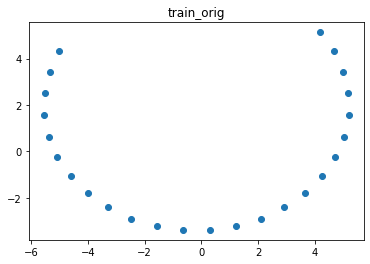

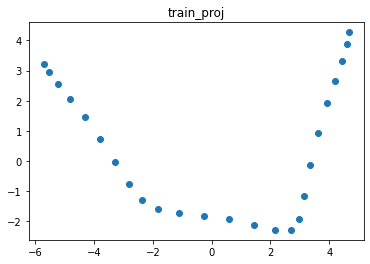

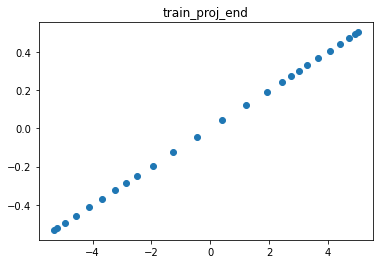

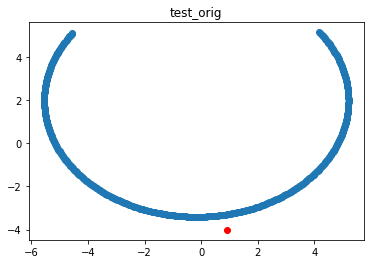

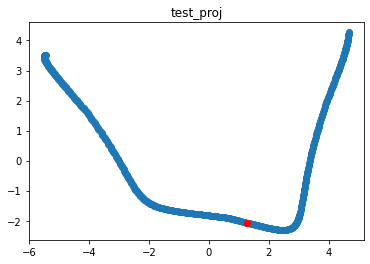

In [53]:
u1 = cc.u.detach().clone().cpu().numpy()
A1_proj = np.eye(d) - u1@u1.T
u2 = cc.u2.detach().clone().cpu().numpy()
A2_proj = np.eye(d) - u2@u2.T
u3 = cc.u3.detach().clone().cpu().numpy()
A3_proj = np.eye(d) - u3@u3.T

alpha2 = align.alpha2.detach().clone().cpu().numpy()
alpha3 = align.alpha3.detach().clone().cpu().numpy()

Z_new = np.zeros(Z.shape)
for i in range(n):
	z_vec = Z[:,[i]]
	# compute local components
	proj1 = A1_proj@z_vec + 2.3*u1
	proj2 = A2_proj@z_vec + alpha2*u2
	proj3 = A3_proj@z_vec + alpha3*u3
	# softmax
	dist1 = np.linalg.norm(z_vec - v1)
	dist2 = np.linalg.norm(z_vec - v2)
	dist3 = np.linalg.norm(z_vec - v3)

	probs = np.array([np.exp(-gamma*dist1), np.exp(-gamma*dist2), np.exp(-gamma*dist3)])
	probs = probs/probs.sum()
	print(probs)

	z_new = proj1*probs[0] + proj2*probs[1] + proj3*probs[2]
	Z_new[:,[i]] = z_new


plt.scatter(Z[0,:], Z[1,:])
plt.title('train_orig')
plt.show()
plt.scatter(Z_new[0,:], Z_new[1,:])
plt.title('train_proj')
plt.show()

u_proj = np.array([-0.1,1]).reshape((2,1))
u_proj = u_proj / np.linalg.norm(u_proj)

Z_new_new = Z_new - u_proj@u_proj.T@Z_new
plt.scatter(Z_new_new[0,:], Z_new_new[1,:])
plt.title('train_proj_end')
plt.show()

scale=2
n_test = 500
Z_test = np.zeros((d,n_test))
for i in range(n_test):
	x = (1.5 - 1.4/2 +1.4*(i+1)/n_test)*np.pi
	Z_test[0,i] = np.cos(x)
	# Z[1,i] = scale*np.sin(x)
	Z_test[1,i] = np.sin(x)


# center and scale (TO ORIGINAL TRAIN DATA)
Z_test = Z_test - Z_mean_orig
Z_test = Z_test * n / Z_norm_orig

# see what mapping is like on test data
test_point = Z_test[:,[250]] + 1*np.random.randn(2,1)

plt.scatter(Z_test[0,:], Z_test[1,:])
plt.scatter(test_point[0,:], test_point[1,:], color='red')
plt.title('test_orig')
plt.show()



for i in range(n_test):
	z_vec = Z_test[:,[i]]
	# compute local components
	proj1 = A1_proj@z_vec + 2*u1
	proj2 = A2_proj@z_vec + alpha2*u2
	proj3 = A3_proj@z_vec + alpha3*u3
	# softmax
	dist1 = np.linalg.norm(z_vec - v1)
	dist2 = np.linalg.norm(z_vec - v2)
	dist3 = np.linalg.norm(z_vec - v3)

	probs = np.array([np.exp(-gamma*dist1), np.exp(-gamma*dist2), np.exp(-gamma*dist3)])
	probs = probs/probs.sum()

	z_new = proj1*probs[0] + proj2*probs[1] + proj3*probs[2]
	Z_test[:,[i]] = z_new



# test point map
z_vec = test_point
# compute local components
proj1 = A1_proj@z_vec + 2.3*u1
proj2 = A2_proj@z_vec + alpha2*u2
proj3 = A3_proj@z_vec + alpha3*u3
# softmax
dist1 = np.linalg.norm(z_vec - v1)
dist2 = np.linalg.norm(z_vec - v2)
dist3 = np.linalg.norm(z_vec - v3)

probs = np.array([np.exp(-gamma*dist1), np.exp(-gamma*dist2), np.exp(-gamma*dist3)])
probs = probs/probs.sum()

z_new = proj1*probs[0] + proj2*probs[1] + proj3*probs[2]
f_test = z_new

plt.scatter(Z_test[0,:], Z_test[1,:])
plt.scatter(f_test[0,:], f_test[1,:], color='red')
plt.title('test_proj')
plt.show()


	

# Smoothed manifold flattening, randomly selecting patches

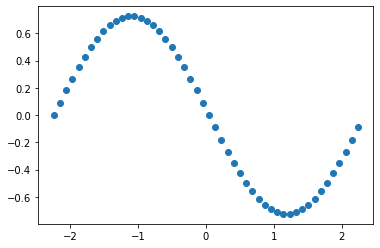

In [211]:
# construct dataset
n = 50
d = 2
X = torch.zeros((n,d))

# hyperparameters
# "size of neighborhood"
gamma = 1
d_target = 1

for i in range(n):
	x_coord = i / n*2*torch.pi
	# X[i,0] = np.cos(x_coord)
	X[i,0] = x_coord
	# Z[1,i] = scale*np.sin(x)
	X[i,1] = np.sin(x_coord)

# center and scale
X_mean = torch.mean(X, dim=0)
X = X - X_mean
X_norm = torch.norm(X)/np.sqrt(n*d)
X = X / X_norm

plt.scatter(X[:,0], X[:,1])
plt.show()


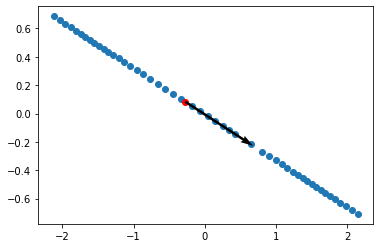

In [213]:
# step and show
gamma=0.1
for _ in range(10):
	# center of neighborhood selection
	choice = torch.randint(n, (1,))
	center = X[choice,:]

	# weighted kernel from current selected point
	kernel_eval = torch.exp(-gamma*torch.sum((X - center)**2, dim=1, keepdim=True))
	kernel_eval = kernel_eval / torch.sum(kernel_eval) #tensor of shape R^(n x 1)

	# weighted mean from current selected point
	kernel_mean = torch.sum(kernel_eval*X, dim=0, keepdim=True)
	# kernel_mean = center

	# record original distances from kernel mean
	X_dist = torch.norm(X - kernel_mean, dim=1, keepdim=True)

	# find new kernel from new center
	kernel_new = torch.exp(-gamma*torch.sum((X - kernel_mean)**2, dim=1, keepdim=True))
	# kernel_new = kernel_new / torch.sum(kernel_new)
	kernel_new = 0.5*kernel_new

	# kernel pca
	U, S, Vt = torch.linalg.svd(torch.sqrt(kernel_new)*(X - kernel_mean))

	pca_kernel = Vt.T[:,:d_target]
	# affine map
	subspace_proj = ((X - kernel_mean)@pca_kernel)@pca_kernel.T + kernel_mean

	# compute POU using kernel
	X = (1-kernel_new)*X + kernel_new*subspace_proj

	# renormalize so kernel evaluation stays the same
	dist_new = torch.norm(X - kernel_mean, dim=1, keepdim=True)
	dist_new[dist_new == 0] = 1e-6
	X = (X - kernel_mean) / dist_new  * X_dist + kernel_mean

plt.scatter(X[:,0], X[:,1])
plt.scatter(kernel_mean[:,0], kernel_mean[:,1], color='red')
plt.quiver(kernel_mean[:,0], kernel_mean[:,1], pca_kernel[0], pca_kernel[1],scale_units='xy', angles='xy',scale=1)
plt.show()

# print(X)

# dummy 2d vision dataset

2-parameter set of 2D images, various brightnesses and x-translations of a centered square

In [5]:
# 2d images will be (res) x (res)
res = 50
# center block will be (block_size) x (block_size)
block_size = 5
# set of coordinates, a matrix of size (N x 2)
# coord[:,0] is the x coordinate, coord[:,1] is the brightness
N = 300
# random tensor fron uniform distribution
coord = torch.rand(N, 2)
# transform 1st dimenion into valid x coordinates
coord[:,0] = block_size//2 + torch.floor(coord[:,0]*(res-block_size))
# transform 2nd to not be completely dark
coord[:,1] = 0.1 + 0.9*coord[:,1]

# construct data
X = torch.zeros(N, res, res)
for i in range(N):
	x = int(coord[i,0].item())
	y = res // 2
	brightness = coord[i,1].item()
	# brightness = 1
	X[i,x-block_size//2:x+block_size//2, y-block_size//2:y+block_size//2] = brightness

# vectorize data. converts (N x res x res) to (N x res^2)

Z = X.view(N, -1)
# get images from vectorized data
# X = Z.view(N, res, res)


ALTERNATIVE DATASET: 1-parameter group just modulating x-position, fixed brightness at 1.

In [101]:
# 2d images will be (res) x (res)
res = 50
# center block will be (block_size) x (block_size)
block_size = 5
# set of coordinates, a matrix of size (N x 2)
# coord[:,0] is the x coordinate, coord[:,1] is the brightness
N = 30
# random tensor fron uniform distribution
coord = torch.rand(N, 1)
# transform 1st dimenion into valid x coordinates
coord[:,0] = block_size//2 + torch.floor(coord[:,0]*(res-block_size))

# construct data
X = torch.zeros(N, res, res)
for i in range(N):
	x = int(coord[i,0].item())
	y = res // 2
	brightness = 1
	# brightness = 1
	X[i,x-block_size//2:x+block_size//2, y-block_size//2:y+block_size//2] = brightness


# if want ordered:

N = res - block_size*2
X = torch.zeros(N, res, res)
for i in range(N):
	x = i
	y = res // 2
	brightness = 1
	# brightness = 1
	X[i,x-block_size//2:x+block_size//2, y-block_size//2:y+block_size//2] = brightness


# vectorize data. converts (N x res x res) to (N x res^2)

Z = X.view(N, -1)
# get images from vectorized data
# X = Z.view(N, res, res)

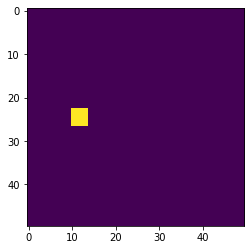

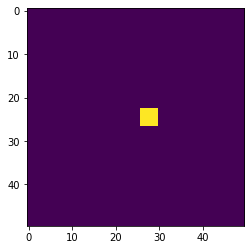

tensor(1.)
tensor(1.)


In [34]:
data1 = 20
data2 =17

plt.imshow(X[data1,:,:].T, vmin=0.0, vmax=1.0)
plt.show()
plt.imshow(X[data2,:,:].T, vmin=0.0, vmax=1.0)
plt.show()

print(Z[data1,:].max())
print(Z[data2,:].max())

In [5]:
U, S, V_pca_full = torch.svd(Z)


In [13]:
# test out or projection from PCA
# OLD CODE
len_test = res - 2*block_size
X1 = torch.zeros(len_test,res,res)
for i in range(len_test):
	x = i + block_size//2
	y = res // 2
	brightness = 1
	X1[i,x-block_size//2:x+block_size//2, y-block_size//2:y+block_size//2] = brightness

Z1 = X1.view(len_test, -1)
Z1_proj1 = Z1@V[:,0]
Z1_proj2 = Z1@V[:,1]

plt.plot(np.arange(len_test), Z1_proj1.numpy())
plt.title('Projection 1')
plt.show()

plt.plot(np.arange(len_test), Z1_proj2.numpy())
plt.title('Projection 2')
plt.show()

NameError: name 'V' is not defined

In [58]:
edm = torch.cdist(Z, Z)
print(torch.exp(-1*edm))

tensor([[1.0000, 0.0035, 0.0035, 0.0035, 0.0591, 0.0035, 0.0035, 0.0035, 0.0035,
         0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035,
         0.0035, 0.0183, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035,
         0.0035, 0.0035, 0.0035],
        [0.0035, 1.0000, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035,
         0.0035, 0.0075, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035,
         0.0035, 0.0035, 0.0035, 0.0591, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035,
         0.0035, 0.0035, 0.0035],
        [0.0035, 0.0035, 1.0000, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035,
         0.0591, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035,
         0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0183, 0.0035, 0.0035,
         0.0035, 0.0035, 0.0035],
        [0.0035, 0.0035, 0.0035, 1.0000, 0.0035, 0.0035, 1.0000, 0.0035, 1.0000,
         0.0075, 0.0035, 0.0035, 0.0035, 0.0035, 0.0075, 0.0183, 0.0035, 0.0035,
       

In [138]:
# NEW METHOD: trying to make computation more efficient
# PyTorch model to optimize our custom loss
class InjectivityPCA(nn.Module):

    def __init__(self, X, u_0):
        super(InjectivityPCA, self).__init__();
        # data
        n, d = X.shape
        self.X = X
        # collect difference vectors. return is of shape (n x n x d)
        diff_full = X.unsqueeze(1) - X
        # return non-redundant difference vectors (keep only i - j instead of i - j and j - i)
        # return of shape is (n(n-1)/2 x d)
        diff_select = torch.ones(diff_full.shape[:2]).triu(diagonal=1)
        diff_select = diff_select.bool()
        self.diff_select = diff_select
        diff = diff_full[diff_select,:]

        # # finally, normalize difference vectors (rows)
        # self.diff = diff / torch.norm(diff, dim=1, keepdim=True)
        # store norms of full diff vec matrix
        diff_norm = torch.norm(diff, dim=1, keepdim=True)
        # make sure no divide by 0 error
        diff_norm[diff_norm == 0] = 1
        self.diff_norm_scale = 1 / diff_norm
        
        # projection vec
        self.U = nn.Parameter(u_0)

    def forward(self):
        # Apply projection vectors to difference vectors
        A = self.X @ self.U
        # Compute diff from projected vectors
        # diff_proj = (A.unsqueeze(1) - A)
        diff_proj = (A[1:,:] - A[:-1,:])[2:, :]
        # remove redundant diffs, normalize
        # diff_proj = diff_proj[self.diff_select,:] * self.diff_norm_scale*10
        # diff_proj = diff_proj[self.diff_select,:]
        
        # average out sample complexity, but not dimension
        return diff_proj.mean()

In [114]:
import time

In [142]:
# METHOD 1: optimize upwards (build up 2-dim subspace to project onto)
n, d = Z.shape
lr = 0.02
d_final = 1
# U_0 = torch.randn(d,d-2)
# Q, R = torch.linalg.qr(U_0)
# U_0 = Q
# u_0 = u_0 / torch.norm(u_0, p=2, dim=0, keepdim=True)


U_0 = torch.randn(d, d_final)
Q, R = torch.linalg.qr(U_0)
U_0 = Q

# U_0 = U_0 / torch.norm(U_0, p=2)

pca_new = InjectivityPCA(Z, U_0.detach().clone())



opt = optim.SGD(pca_new.parameters(), lr=lr)

loss_prev = -1

start = time.perf_counter()


for i in range(9000):
    pca_new.zero_grad()
    # forward call of LinFlow
    loss = pca_new()

    loss.backward()

    # compute Riemannian gradient
    # egrad = pca_new.u.grad.detach()
    # base = pca_new.u.data.detach()
    # base = base / torch.sqrt(base.pow(2).sum())
    # rgrad = egrad - base@base.t()@egrad
    # GD step
    opt.step()
    # renormalization step
    with torch.no_grad():
        # multi-dim case
        Q, R = torch.linalg.qr(pca_new.U)
        pca_new.U.data = Q

        # one-at-a-time case
        # # project to current subspace
        # if N.numel() > 1:
        #     pca_new.U.data = pca_new.U.data - N@(N.T@pca_new.U.data)
        # # normalize
        # pca_new.U.data = pca_new.U.data / torch.norm(pca_new.U.data, p=2)

    # determine if we have converged
    # gradnorm = torch.linalg.norm(rgrad)
    # if loss_prev != -1 and torch.abs((loss - loss_prev)).item() < 1e-6:
    # 	print(f'converged in {i} steps! final loss: {loss.item()}')
    # 	break
    if i % 500 == 0 or i==5:
        print(f'step {i}: {loss.item():.4f}')
        # print(f'g step {i}: {gradnorm}')
    loss_prev = loss.detach()


print('done!')
print(f'time: {time.perf_counter() - start}s')
P_final = pca_new.U.data.clone()

step 0: -0.0018
step 5: -0.0042
step 500: -0.1394
step 1000: -0.1522
step 1500: -0.1529
step 2000: -0.1529
step 2500: -0.1529
step 3000: -0.1529
step 3500: -0.1529
step 4000: -0.1529
step 4500: -0.1529
step 5000: -0.1529
step 5500: -0.1529
step 6000: -0.1529
step 6500: -0.1529
step 7000: -0.1529
step 7500: -0.1529
step 8000: -0.1529
step 8500: -0.1529
done!
time: 7.712584699969739s


In [327]:
n, d = Z.shape
lr = 0.02
d_final = 2
# U_0 = torch.randn(d,d-2)
# Q, R = torch.linalg.qr(U_0)
# U_0 = Q
# u_0 = u_0 / torch.norm(u_0, p=2, dim=0, keepdim=True)


U_0 = torch.randn(d, 1)
# Q, R = torch.linalg.qr(pca_new.U)
# pca_new.U.data = Q

U_0 = U_0 / torch.norm(U_0, p=2)

pca_new = InjectivityPCA(Z_pca, U_0.detach().clone())



opt = optim.SGD(pca_new.parameters(), lr=lr)

loss_prev = -1

start = time.perf_counter()

for k in range(d - d_final):

    for i in range(3000):
        pca_new.zero_grad()
        # forward call of LinFlow
        loss = pca_new()

        loss.backward()

        # compute Riemannian gradient
        # egrad = pca_new.u.grad.detach()
        # base = pca_new.u.data.detach()
        # base = base / torch.sqrt(base.pow(2).sum())
        # rgrad = egrad - base@base.t()@egrad
        # GD step
        opt.step()
        # renormalization step
        with torch.no_grad():
            # multi-dim case
            Q, R = torch.linalg.qr(pca_new.U)
            pca_new.U.data = Q

            # one-at-a-time case
            # # project to current subspace
            # if N.numel() > 1:
            #     pca_new.U.data = pca_new.U.data - N@(N.T@pca_new.U.data)
            # # normalize
            # pca_new.U.data = pca_new.U.data / torch.norm(pca_new.U.data, p=2)

        # determine if we have converged
        # gradnorm = torch.linalg.norm(rgrad)
        # if loss_prev != -1 and torch.abs((loss - loss_prev)).item() < 1e-6:
        # 	print(f'converged in {i} steps! final loss: {loss.item()}')
        # 	break
        if i % 500 == 0 or i==5:
            print(f'step {i}: {loss.item():.4f}')
            # print(f'g step {i}: {gradnorm}')
        loss_prev = loss.detach()


print('done!')
print(f'time: {time.perf_counter() - start}s')
P_final = pca_new.U.data

# construct projection
T = torch.eye(d) - N@N.T
U, S, V = torch.svd(T)
U_final = U[:,:d_final]
# vv this is the map we hope flattens Z (Z@P_final)
P_final = V_pca@U_final


dim: 50 step 0: 2.3093
dim: 50 step 5: 0.1568
dim: 50 step 500: 0.0013
dim: 50 step 1000: 0.0006
dim: 50 step 1500: 0.0004
dim: 50 step 2000: 0.0003
dim: 50 step 2500: 0.0003
dim: 49 step 0: 2.4871
dim: 49 step 5: 0.2189
dim: 49 step 500: 0.0047
dim: 49 step 1000: 0.0016
dim: 49 step 1500: 0.0008
dim: 49 step 2000: 0.0005
dim: 49 step 2500: 0.0004
dim: 48 step 0: 2.1420
dim: 48 step 5: 0.2931
dim: 48 step 500: 0.0059
dim: 48 step 1000: 0.0025
dim: 48 step 1500: 0.0016
dim: 48 step 2000: 0.0011
dim: 48 step 2500: 0.0009
dim: 47 step 0: 1.9043
dim: 47 step 5: 0.2781
dim: 47 step 500: 0.0038
dim: 47 step 1000: 0.0015
dim: 47 step 1500: 0.0009
dim: 47 step 2000: 0.0006
dim: 47 step 2500: 0.0004
dim: 46 step 0: 2.4118
dim: 46 step 5: 0.2372
dim: 46 step 500: 0.0020
dim: 46 step 1000: 0.0009
dim: 46 step 1500: 0.0007
dim: 46 step 2000: 0.0005
dim: 46 step 2500: 0.0005
dim: 45 step 0: 2.1966
dim: 45 step 5: 0.2695
dim: 45 step 500: 0.0059
dim: 45 step 1000: 0.0029
dim: 45 step 1500: 0.0019
di

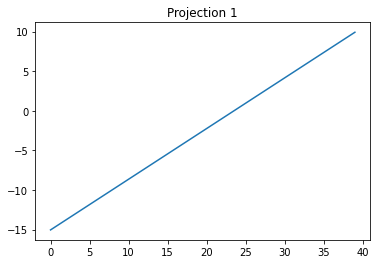

In [210]:
# OLD CODE
# u_proj = u_learned.detach().clone()
u_proj = torch.zeros(res,res)
for i in range(res):
	u_proj[i,:] = (i- res / 2) / (res / 2)
u_proj = u_proj.view(1, -1).T

# test out or projection from PCA
len_test = res - 2*block_size
X1 = torch.zeros(len_test,res,res)
for i in range(len_test):
	x = i + block_size//2
	y = res // 2
	brightness = 1
	X1[i,x-block_size//2:x+block_size//2, y-block_size//2:y+block_size//2] = brightness

Z1 = X1.view(len_test, -1)
Z1_proj1 = Z1@u_proj

plt.plot(np.arange(len_test), Z1_proj1.numpy())
plt.title('Projection 1')
plt.show()

# plt.plot(np.arange(len_test), Z1_proj2.numpy())
# plt.title('Projection 2')
# plt.show()

View projections, 2D data

torch.Size([300, 2])


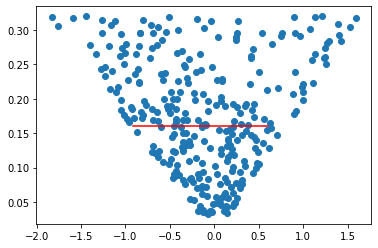

In [22]:
u_proj1 = torch.zeros(res,res)
for i in range(res):
	u_proj1[i,:] = (i- res / 2) / (res / 2)
u_proj1[:,:res//2 - block_size//2] = 0
u_proj1[:,res//2 + block_size//2:] = 0
u_proj1 = u_proj1.view(1, -1).T
u_proj2 = torch.ones(res**2, 1)
# normalize
u_proj1 = u_proj1 / torch.norm(u_proj1, p=2)
u_proj2 = u_proj2 / torch.norm(u_proj2, p=2)

# U = torch.hstack((V_pca_full[:,[0]], V_pca_full[:,[1]]))
U = torch.hstack((u_proj1, u_proj2))
# U = P_final
# U= u_proj1
# U = torch.randn(U.shape)
Z_proj = Z@U
print(Z_proj.shape)
plt.scatter(Z_proj[:,0].numpy(), Z_proj[:,1].numpy())

# show geodesic
len_test = res - 2*block_size
X1 = torch.zeros(len_test,res,res)
for i in range(len_test):
	x = i + block_size//2
	y = res // 2
	brightness = 0.5
	X1[i,x-block_size//2:x+block_size//2, y-block_size//2:y+block_size//2] = brightness

Z1 = X1.view(len_test, -1)
Z1_proj1 = Z1@U
plt.plot(Z1_proj1[:,0].numpy(), Z1_proj1[:,1].numpy(), c='r')
# plt.plot(np.arange(len_test), Z1_proj1[:].numpy(), c='r')
plt.show()

View projections, 1D data

In [43]:
print(Z.shape)
print((Z@u_proj1)[:].shape)

torch.Size([300, 2500])
torch.Size([300, 1])


In [45]:
vals, indices = (Z@u_proj1).reshape(N).sort()
Z_sort = (Z@u_proj1)[indices]
# print(args)
print(Z_sort)

tensor([[-1.8413],
        [-1.8413],
        [-1.8413],
        [-1.8413],
        [-1.8413],
        [-1.8413],
        [-1.8413],
        [-1.8413],
        [-1.8413],
        [-1.8413],
        [-1.8413],
        [-1.7629],
        [-1.7629],
        [-1.7629],
        [-1.7629],
        [-1.7629],
        [-1.6846],
        [-1.6846],
        [-1.6846],
        [-1.6846],
        [-1.6846],
        [-1.6062],
        [-1.6062],
        [-1.6062],
        [-1.6062],
        [-1.6062],
        [-1.5279],
        [-1.5279],
        [-1.4495],
        [-1.4495],
        [-1.4495],
        [-1.4495],
        [-1.4495],
        [-1.4495],
        [-1.4495],
        [-1.3712],
        [-1.3712],
        [-1.3712],
        [-1.3712],
        [-1.2928],
        [-1.2928],
        [-1.2145],
        [-1.2145],
        [-1.2145],
        [-1.2145],
        [-1.2145],
        [-1.2145],
        [-1.2145],
        [-1.1361],
        [-1.1361],
        [-1.1361],
        [-1.1361],
        [-1.

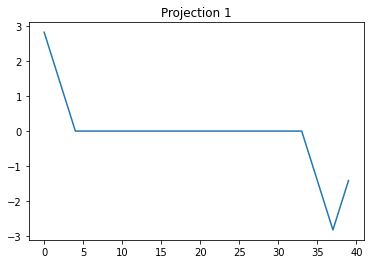

In [143]:
N = Z.shape[0]
u_proj1 = torch.zeros(res,res)
for i in range(res):
	u_proj1[i,:] = (i- res / 2) / (res / 2)
u_proj1[:,:res//2 - block_size//2] = 0
u_proj1[:,res//2 + block_size//2:] = 0
u_proj1 = u_proj1.view(1, -1).T
# normalize
u_proj1 = u_proj1 / torch.norm(u_proj1, p=2)

# U = V_pca_full[:,[0]]
# U = u_proj1
U = P_final
# U= u_proj1
# U = torch.randn(U.shape)

# test out or projection from PCA
len_test = res - 2*block_size
X1 = torch.zeros(len_test,res,res)
for i in range(len_test):
	x = i + block_size//2
	y = res // 2
	brightness = 1
	X1[i,x-block_size//2:x+block_size//2, y-block_size//2:y+block_size//2] = brightness

Z1 = X1.view(len_test, -1)
Z1_proj1 = Z1@U

plt.plot(np.arange(len_test), Z1_proj1.numpy())
plt.title('Projection 1')
plt.show()

plotting filters

min: -0.1767767369747162 max: 0.1767767369747162


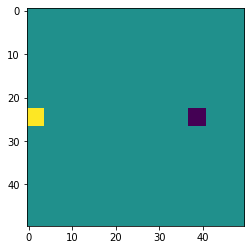

In [144]:
filt = P_final.view(res, res)

plt.imshow(filt.T)
print(f'min: {filt.min()} max: {filt.max()}')

In [1]:
U, S, V = torch.svd(Z)
U = torch.hstack((V[:,[0]], V[:,[1]]))
filters = U.T.view(d_final, res, res)

plt.imshow(filters[0,:,:].T)
print(f'min: {filters[0,:,:].min()} max: {filters[0,:,:].max()}')
plt.show()
plt.imshow(filters[1,:,:].T, vmin=0.0, vmax=1.0)
print(f'min: {filters[1,:,:].min()} max: {filters[1,:,:].max()}')
plt.show()


NameError: name 'torch' is not defined

# test regen (TO TEST)

In [55]:
# init data construction
N = 100
X = torch.zeros(N, 2)
# half circle
for i in range(N):
    # x_coord = np.pi*i/N + np.pi
    x_coord = 2*np.pi*i/N
    # X[i, 0] = np.cos(np.pi*i/N + np.pi)
    X[i, 0] = x_coord
    X[i, 1] = np.sin(x_coord)

X = X + torch.Tensor([0, 1])
rot = torch.randn(2,2)
Q, R = torch.linalg.qr(rot)
rot = Q
# X = X@rot

# random manifold
manifold = Manifold(3, 2)
X = manifold.generateSample(N)

X_0 = X.clone()

# fidelity term for how close to max radius to get
# fid = 10
# number of flattening steps per cell eval
n_iter = 50
# how many max steps for inner optimization of U, V
n_iter_inner = 10000
# threshold for reconstruction loss being good enough
thres_recon = 1e-4
log2 = float(np.log(2))
alpha_max = 0.5

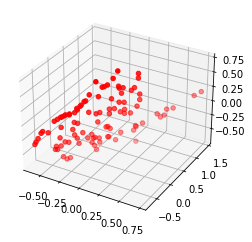

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X[:, 0], X[:,1], X[:,2], c='b')
ax.scatter(Z[:, 0], Z[:,1], Z[:,2], c='r')
# ax.scatter(Xhat[:, 0], Xhat[:,1], Xhat[:,2], c='c')
plt.show()

In [57]:
def opt_UV(Z, z_c, U_0, n_iter_inner, r=-1, kernel=-1):
	# optimize U, V
	U = torch.nn.Parameter(U_0.clone())
	U.requires_grad = True

	opt_U = optim.SGD([U], lr=1)

	# must specify either r or kernel
	if type(r) != torch.Tensor and type(kernel) != torch.Tensor:
		raise ValueError('Must specify either r or kernel')

	# init kernel
	if type(kernel) != torch.Tensor:
		gamma = float(np.log(2))/(r**2)
		kernel_pre = torch.exp(-gamma*(Z - z_c).pow(2).sum(dim=1, keepdim=True))
		z_mu = (Z*kernel_pre).sum(dim=0, keepdim=True) / kernel_pre.sum()
		kernel = torch.exp(-gamma*(Z - z_mu).pow(2).sum(dim=1, keepdim=True))
	
	# optimize U
	for i in range(n_iter_inner):
		U_old = U.data.clone()
		opt_U.zero_grad()
		# opt_V.zero_grad()
		# opt_alpha.zero_grad()
		coord = (Z - z_c) @ U
		Z_perp = (Z - z_c) - coord @ U.T
		coord2 = coord.pow(2)
		A = coord2 * kernel
		b = Z_perp * kernel

		# least squares solution for V, note automatically orthogonal to U
		with torch.no_grad():
			V = ((A.T@A).inverse() @ (A.T@b)).T

		loss = 0.5*(kernel*(Z_perp - coord2@V.T)).pow(2).mean()
		# loss = (U).pow(2).mean()
		loss.backward()

		opt_U.step()
		# update to gradient

		with torch.no_grad():
			
			# project onto Steifel manifold
			if U.data.shape[1] == 1:
				U.data = U.data / torch.norm(U.data, p=2)
			else:
				U_svd, S_svd, Vh_svd = torch.linalg.svd(U.data, full_matrices=False)
				U.data = U_svd@Vh_svd

			step_size = (U.data - U_old).pow(2).mean().sqrt()
			U_old = U.data.clone()

			if step_size < 1e-5:
				break
			
	loss_final = 0.5*(kernel*(Z_perp - coord2@V.T)).pow(2).mean()
	return U.detach().data, V.detach().data, loss_final.detach()

def find_d(Z, z_c, r_dimcheck, n_iter_inner):
	# We find the minimial d by iteratively fitting a model
	# for some size d, then increase d and repeat if the max
	# reconstruction error is too large

	max_error_ratio = 0.4

	N, D = Z.shape
	# init
	U_0 = torch.randn(D, 1)
	U_0 = U_0 / torch.norm(U_0, p=2)

	# init tracking variable
	max_error = max_error_ratio*r_dimcheck

	# note kernel will stay the same for all d
	gamma = float(np.log(2))/(r_dimcheck**2)
	kernel_pre = torch.exp(-gamma*(Z - z_c).pow(2).sum(dim=1, keepdim=True))
	z_mu = (Z*kernel_pre).sum(dim=0, keepdim=True) / kernel_pre.sum()
	kernel = torch.exp(-gamma*(Z - z_mu).pow(2).sum(dim=1, keepdim=True))

	while max_error >= max_error_ratio*r_dimcheck:
		U, V, loss = opt_UV(Z, z_c, U_0, n_iter_inner, kernel=kernel)

		# compute max error, if too large, increase d
		coord = (Z - z_c) @ U
		Z_perp = (Z - z_c) - coord @ U.T
		coord2 = coord.pow(2)
		max_error = (kernel*(Z_perp - coord2@V.T)).norm(dim=1).max()
		# print(f'current max error: {max_error}')
		# print(f'max error thredhold: {max_error_ratio*r_dimcheck}')
		if max_error >= max_error_ratio*r_dimcheck:
			# add new vec , orthogonalize via gram schmidt
			U_new = torch.randn(D, 1)
			U_new = U_new - U @ (U.T@U_new)
			U_new = U_new / torch.norm(U_new, p=2)
			U_0 = torch.cat((U, U_new), dim=1).clone()


	return U.detach().data, loss.detach().data

100%|██████████| 50/50 [02:05<00:00,  2.51s/iters, loss=1.77e-8, d=2, alpha=0.5, r_ratio=1]      


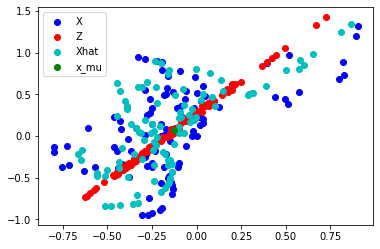

In [58]:
f = CCNetwork()
g = CCNetwork()
X = X_0.clone()

EDM_X = torch.cdist(X, X,p=2)
# radius for checking dimension. Should be as small as possible,
# but big enough that at every point there's at least one sample
# along every intrinsic dimension
r_dimcheck = 0.25*EDM_X.max()
# minimum allowed radius for each flattening
# want this to be relatively larger to converge to flat
# representation faster
r_min = 0.25*EDM_X.max()
# maximum allowed radius for each flattening
r_max = 1.1*EDM_X.max()
# minimum step size for determining optimal radius
r_step_min = EDM_X[EDM_X > 0].min()

with trange(n_iter, unit="iters") as pbar:
	for j in pbar:
		# STEP 0: stochastically choose center of the neighborhood to
		# flatten and reconstruct
		choice = torch.randint(N, (1,))
		x_c = X[choice,:]

		# STEP 1: find minimal dimension d we can flatten neighborhood
		# to and still be able to reconstruct

		# note d is implicitly returned, as U, V are of shape (D, d)
		U, loss_rdimcheck = find_d(X, x_c, r_dimcheck, n_iter_inner)
		# STEP 2: use secant method to find maximal radius that achieves
		# desired reconstruction loss

		# get needed second observation
		U, V, loss_rmidpoint = opt_UV(X, x_c, U, n_iter_inner, r=(r_min + r_max)/2)

		# begin secant method (note we use log loss for numerical reasons)
		log_thres_recon = torch.log(torch.Tensor([thres_recon]))
		r_m2 = r_dimcheck
		f_m2 = torch.log(loss_rdimcheck) - log_thres_recon
		r_m1 = (r_min + r_max)/2
		f_m1 = torch.log(loss_rmidpoint) - log_thres_recon

		while torch.abs(r_m1 - r_m2) > r_step_min:

			# threshold denominator for numerical stability
			f_diff = f_m1 - f_m2
			if torch.abs(f_diff) < 1e-6:
				if f_diff >= 0:
					f_diff = 1e-6
				else:
					f_diff = -1e-6

			r = r_m1 - (r_m1 - r_m2)/f_diff*f_m1

			# if we reach either boundary, threshold and exit
			if r < r_min:
				r = r_min
			elif r > r_max:
				r = r_max

			U, V, loss_r = opt_UV(X, x_c, U, n_iter_inner, r=r)
			f_r = torch.log(loss_r) - log_thres_recon

			r_m2 = r_m1.clone()
			f_m2 = f_m1.clone()
			r_m1 = r.clone()
			f_m1 = f_r.clone()

			

		# STEP 3: line search for biggest alpha that gets us to desired fidelity
		alpha = float(min(alpha_max, np.sqrt(thres_recon / loss_r.item())))
		# STEP 4: add layer to network
		X = X.detach()
		U = U.detach().clone()
		V = V.detach().clone()

		gamma = float(np.log(2))/(r.item()**2)
		kernel_pre = torch.exp(-gamma*(X - x_c).pow(2).sum(dim=1, keepdim=True))
		x_mu = (X*kernel_pre).sum(dim=0, keepdim=True) / kernel_pre.sum()

		f_layer = FLayer(U, x_mu, gamma, alpha)
		g_layer = GLayer(U, V, x_mu, x_c, gamma, alpha)

		f.add_operation(f_layer)
		g.add_operation(g_layer)
		# update data
		X = f_layer(X).clone()
		pbar.set_postfix({"loss": loss_r.item(), "d": U.shape[1], "alpha": alpha, "r_ratio": (r/r_max).item()})
		
Z = f(X_0)
Xhat = g(Z)
# ########################################################

# # reevaluate kernel from x_mu
# kernel = torch.exp(-gamma*(X - x_mu).pow(2).sum(dim=1, keepdim=True))

# # print(X - X*kernel)
# Z = ((X - x_mu)@U@U.T + x_mu)*kernel + X*(1 - kernel)
# coord = (Z - x_c)@U
# change = x_c - x_mu
# change = change - (change@U)@U.T
# # Xhat = Z + change - (change@U)@U.T + (coord.pow(2))@V.T
# Xhat = Z + kernel*(change + (coord.pow(2))@V.T)
plt.scatter(X_0[:, 0], X_0[:,1], c='b')
plt.scatter(Z[:, 0], Z[:,1], c='r')
plt.scatter(Xhat[:, 0], Xhat[:,1], c='c')
plt.scatter(x_mu[0,0], x_mu[0,1], c='g')
# plt.quiver(x_c[0], x_c[1], U[0], U[1], scale_units='xy', angles='xy',scale=1)
# V = V / V.norm()
# plt.quiver(x_c[0], x_c[1], V[0], V[1], scale_units='xy', angles='xy',scale=1, color='g')
plt.legend(['X', 'Z', 'Xhat', 'x_mu'])
plt.show()


In [41]:
print(U.grad.data)

AttributeError: 'NoneType' object has no attribute 'data'

In [4]:
class CCNetwork(nn.Module):
	def __init__(self):
		super(CCNetwork, self).__init__()
		self.network = torch.nn.Sequential()
		
	def forward(self, X):
		return self.network(X)

	def add_operation(self, nn_module, name = '_'):
		# if no name, just indicate which layer it is
		if name == '_':
			name = f'layer {len(self.network)}'
		self.network.add_module(name, nn_module)

class FLayer(nn.Module):
	def __init__(self, U, x_mu, gamma, alpha=1):
		super(FLayer, self).__init__()
		self.U = U
		self.D, self.k = U.shape
		self.x_mu = x_mu
		self.gamma = gamma
		self.alpha = alpha

		
	def forward(self, X):
		# X: tensor of shape N x D, a batch of N points in D dimensions
		# that we want to flatten by 1 step

		# returns: tensor of shape N x D

		kernel = self.alpha*torch.exp(-self.gamma*(X - self.x_mu).pow(2).sum(dim=1, keepdim=True))
		self.kernel = kernel
		proj = (X - self.x_mu)@self.U@self.U.T + self.x_mu
		Z = proj*kernel + X*(1 - kernel)

		return Z


class GLayer(nn.Module):
	def __init__(self, U, V, x_mu, x_c, gamma, alpha=1):
		super(GLayer, self).__init__()
		self.U = U
		self.V = V
		self.D, self.k = U.shape #U, V have same shape
		self.x_mu = x_mu
		self.x_c = x_c
		self.gamma = gamma
		self.alpha = alpha

		# computations we don't need to repeat every evaluation
		self.x_muU = x_mu @ U
		self.x_cU = x_c @ U
		self.change = x_c - x_mu - (self.x_cU - self.x_muU)@U.T

		
	def forward(self, Z):
		# Z: tensor of shape N x D, a batch of N points in D dimensions
		# that we want to flatten by 1 step

		# returns: tensor of shape N x D

		ZU = Z@self.U
		Z_norm2 = (Z-self.x_mu).pow(2).sum(dim=1, keepdim=True)
		ZU_norm2 = (ZU - self.x_muU).pow(2).sum(dim=1, keepdim=True)
		kernel = kernel_inv(Z_norm2, ZU_norm2, self.gamma, self.alpha)
		self.kernel = kernel

		coord = ZU - self.x_cU
		Xhat = Z + kernel*(self.change + (coord.pow(2))@(self.V).T)

		return Xhat
# implementation of secant method. converge once step size of all
# below machine precision
# TODO: look into if this inversion is well-conditioned
def kernel_inv(Z_norm2, ZU_norm2, gamma, alpha):
	

	# parameter setup
	ZUperp_norm2 = Z_norm2 - ZU_norm2
	exp_gammaz = torch.exp(-gamma*ZU_norm2)

	# initial guess
	guess_ratio = 1 - 1e-3
	# x_{n-2}
	x_m2 = ZUperp_norm2 * guess_ratio
	# x_{n-1}
	x_m1 = ZUperp_norm2

	x = x_m1
	# track size of each step
	step_size = 1

	# find inverse by root-finding using secant method
	
	while step_size > 1e-6:
		f_m1 = (1-alpha*exp_gammaz*torch.exp(-gamma*x_m1)).pow(2)*x_m1 - ZUperp_norm2
		f_m2 = (1-alpha*exp_gammaz*torch.exp(-gamma*x_m2)).pow(2)*x_m2 - ZUperp_norm2

		f_diff = f_m1 - f_m2
		f_diff[torch.logical_and(f_diff.abs() < 1e-6, f_diff >= 0)] = 1e-6
		f_diff[torch.logical_and(f_diff.abs() < 1e-6, f_diff < 0)] = -1e-6

		x = x_m1 - f_m1*(x_m1 - x_m2)/f_diff

		step_size = torch.abs(x - x_m1).max()
		x_m2 = x_m1
		x_m1 = x

	# return inverse
	return alpha*torch.exp(-gamma*(ZU_norm2 + x))


In [323]:
A = torch.randn(3,2)
hi = (A.T@A).inverse() @ A.T
hi2 = torch.linalg.pinv(A)
print(hi - hi2)

tensor([[ 0.0000e+00,  5.9605e-08, -2.9802e-08],
        [ 1.1921e-07, -2.9802e-08,  0.0000e+00]])


In [334]:
A = torch.randn(3,2)
print(A)
print(A / A.norm(dim=1, keepdim=True))

tensor([[ 2.8393, -0.3808],
        [ 0.2958,  0.0835],
        [ 0.8531, -0.2838]])
tensor([[ 0.9911, -0.1329],
        [ 0.9624,  0.2718],
        [ 0.9489, -0.3157]])


In [335]:
# OLD ###########################################
f = CCNetwork()
g = CCNetwork()
X = X_0.clone()
# min loss w.r.t gamma is monotonic, so we can just do a binary search
# to find the lowest gamma
with trange(n_iter, unit="iters") as pbar:
	for _ in pbar:

		# start our "neighborhood size" at max possible
		r_max = torch.cdist(X, X).max()
		r_init = r_max.clone() / 2
		r_curr = r_init.clone()

		# 1 step of flattening/regeneration
		choice = torch.randint(N, (1,))
		# choice=25
		x_c = X[choice,:]

		U_0 = torch.randn(2, 1)
		U_0 = U_0 / torch.norm(U_0, p=2)
		U = torch.nn.Parameter(U_0.clone())
		U.requires_grad = True


		opt_U = optim.SGD([U], lr=1)
	# outer loop, searching for max radius with desired fidelity
		for i in range(fid):
			# set up kernel
			gamma = log2/r_curr**2
			kernel_pre = torch.exp(-gamma*(X - x_c).pow(2).sum(dim=1, keepdim=True))
			x_mu = (X*kernel_pre).sum(dim=0, keepdim=True) / kernel_pre.sum()
			kernel = alpha*torch.exp(-gamma*(X - x_mu).pow(2).sum(dim=1, keepdim=True))

			U_old = U.data.clone()
			# inner loop, find best U, V to reconstruct
			for _ in range(n_iter_inner):
				opt_U.zero_grad()
				# opt_V.zero_grad()
				# opt_alpha.zero_grad()
				coord = (X - x_c) @ U
				coord2 = coord.pow(2)
				X_perp = (X - x_c) - coord @ U.T
				A = coord2 * kernel
				b = X_perp * kernel

				# least squares solution for V, note automatically orthogonal to U
				# with torch.no_grad():
				V = ((A.T@A).inverse() @ (A.T@b)).T

				loss = 0.5*(kernel*(X_perp - coord2@V.T)).pow(2).mean()
				# loss = (U).pow(2).mean()
				loss.backward()

				opt_U.step()
				with torch.no_grad():
					U.data = U.data / torch.norm(U.data, p=2)
					step_size = (U.data - U_old).pow(2).mean().sqrt()
					U_old = U.data.clone()

					if step_size < 1e-5:
						break
			
			# achieved desired recon loss, so increase neighborhood
			# size
			if loss.item() <= thres_recon:
				d_curr += d_init * (0.5)**(i+1)
			# didn't achieve desired recon loss, so decrease neighborhood
			else:
				d_curr -= d_init * (0.5)**(i+1)

			# if radius already bigger than biggest possible, no need to continue searching
			if d_curr > d_max:
				break

		# line search for biggest alpha that gets us to desired fidelity


		X = X.detach()
		U = U.detach()
		V = V.detach()

		f_layer = FLayer(U, x_mu, gamma, alpha)
		g_layer = GLayer(U, V, x_mu, x_c, gamma, alpha)

		f.add_operation(f_layer)
		g.add_operation(g_layer)
		# update data
		X = f_layer(X).clone()
		pbar.set_postfix({"loss": loss.item(), "d_ratio": (d_curr/d_max).item()})
		
Z = f(X_0)
Xhat = g(Z)

In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

In [46]:
dataset = MNIST(root='./torch-dataset', train=True,
								download=True, transform=transform)

# load dataset into pytorch
data_loader = torch.utils.data.DataLoader(dataset, batch_size=600000)
data,labels = next(iter(data_loader))
# data = data.cuda()

# select single class of dataset
X = data[labels==2]

print(X.shape)

torch.Size([5958, 1, 28, 28])


In [79]:
# compute the 2d fourier transform of the data
X_f = torch.fft.fft2(X)
print(X_f.imag.shape)

X_f_real_flat = X_f.real.reshape(X_f.shape[0], -1)
X_f_imag_flat = X_f.imag.reshape(X_f.shape[0], -1)
Z = torch.cat([X_f_real_flat, X_f_imag_flat], dim=1)
print(Z.shape)

Z_mean = Z.mean(dim=0, keepdim=True)

U, S, Vt = torch.linalg.svd(Z - Z_mean, full_matrices=False)
V = Vt.T
# num_nonzero = S[S > 1000].numel()
num_nonzero = 100

Z_c = (Z - Z_mean)@V[:,:num_nonzero]

print(Z_c.shape)

# reconstruction
X_hat = Z_c@V[:,:num_nonzero].T + Z_mean
print(X_hat.shape)
X_hat_real = X_hat[:,:X_f.shape[2]*X_f.shape[3]].reshape(X_f.shape)
X_hat_imag = X_hat[:,X_f.shape[2]*X_f.shape[3]:].reshape(X_f.shape)
X_hat_f = X_hat_real + 1j*X_hat_imag
X_hat = torch.fft.ifft2(X_hat_f).real
print(X_hat.shape)


torch.Size([5958, 1, 28, 28])
torch.Size([5958, 1568])
torch.Size([5958, 100])
torch.Size([5958, 1568])
torch.Size([5958, 1, 28, 28])


In [93]:
Z2 = X.reshape(X.shape[0], -1)
U, S, Vt = torch.linalg.svd(Z2 - Z2.mean(dim=0, keepdim=True), full_matrices=False)
V = Vt.T
Z2_c = (Z2 - Z2.mean(dim=0, keepdim=True))@V[:,:100]
# Z2_c = torch.randn_like(Z2_c)
X_hat2 = Z2_c@V[:,:100].T + Z2.mean(dim=0, keepdim=True)
X_hat2 = X_hat2.reshape(X.shape)

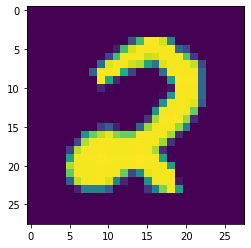

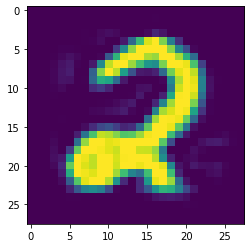

In [94]:
# choose random number between 0 and X.shape[0]
rand_num = np.random.randint(0, X.shape[0])
to_show = X[rand_num,0,:,:].detach().cpu()
to_show2 = X_hat2[rand_num,0,:,:].detach().cpu()
plt.imshow(to_show, vmin=0, vmax=1)
plt.show()
plt.imshow(to_show2, vmin=0, vmax=1)
plt.show()

In [1]:
import sys
sys.path.append('../')
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision import transforms

import cc
from models.vae import train_vanilla_vae, train_beta_vae, train_factor_vae
from tools.manifold_generator import Manifold
# from tools.randman import RandMan

# magic argparser library thank you github.com/brentyi
import dataclasses
import dcargs

from datetime import datetime
import json
import os

In [4]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
# Load the proper dataset

# DATA PREP
transform = transforms.Compose([
	# you can add other transformations in this list
	transforms.ToTensor()
])

dataset = MNIST(root='./torch-dataset', train=True,
						download=True,  transform=transform)

# load dataset into pytorch
data_loader = torch.utils.data.DataLoader(dataset, batch_size=600000)
data,labels = next(iter(data_loader))
data = data.cuda()

# select single class of dataset
X_data = data[labels==5]
X_f = torch.fft.fft2(X_data)

X_f_real_flat = X_f.real.reshape(X_f.shape[0], -1)
X_f_imag_flat = X_f.imag.reshape(X_f.shape[0], -1)
X = torch.cat([X_f_real_flat, X_f_imag_flat], dim=1)

X_mean = X.mean(dim=0, keepdim=True)

U, S, Vt = torch.linalg.svd(X - X_mean, full_matrices=False)
V_X = Vt.T
# num_nonzero = S[S > 1000].numel()
num_nonzero = 100

X_c = (X - X_mean)@V_X[:,:num_nonzero]
X = X_c

# center and scale data. not explicitly needed for cc, but helps numerically
X_norm = X.pow(2).mean().sqrt() #expeded norm of gaussian is sqrt(D)
X = X / X_norm


f, g = cc.cc(X)

100%|██████████| 220/220 [27:14<00:00,  7.43s/iters, local_recon=8.86e-9, d=12, r_ratio=0.231, alpha=0.5]  


In [6]:
Z = f(X)
X_hat = g(Z)
U, S, Vt = torch.linalg.svd(Z - torch.mean(Z, dim=0, keepdims=True), full_matrices=False)
print(S)

tensor([2.4200e+02, 1.9907e+02, 1.5332e+02, 1.2356e+02, 1.1491e+02, 1.0804e+02,
        1.0156e+02, 8.7724e+01, 8.0735e+01, 7.0771e+01, 6.3294e+01, 6.0093e+01,
        5.0508e-01, 8.4672e-02, 4.2704e-02, 3.3636e-02, 2.9424e-02, 2.2047e-02,
        1.6282e-02, 1.4920e-02, 1.3545e-02, 1.2963e-02, 1.2615e-02, 1.1255e-02,
        9.8534e-03, 9.0181e-03, 8.3577e-03, 7.8689e-03, 7.4564e-03, 6.9806e-03,
        6.5537e-03, 6.1785e-03, 5.8497e-03, 5.0071e-03, 4.6990e-03, 4.4637e-03,
        4.3907e-03, 4.1887e-03, 4.0264e-03, 3.7240e-03, 3.6440e-03, 3.3940e-03,
        3.3023e-03, 2.9649e-03, 2.9066e-03, 2.6790e-03, 2.6076e-03, 2.4984e-03,
        2.2641e-03, 2.1514e-03, 2.0733e-03, 1.9043e-03, 1.8468e-03, 1.7895e-03,
        1.5705e-03, 1.4461e-03, 1.3985e-03, 1.2592e-03, 1.2164e-03, 1.1461e-03,
        1.1116e-03, 1.0528e-03, 9.5406e-04, 8.8916e-04, 8.7528e-04, 8.5211e-04,
        7.5942e-04, 7.0246e-04, 6.7404e-04, 6.3728e-04, 6.0429e-04, 5.7010e-04,
        5.2996e-04, 4.7992e-04, 4.5895e-

In [7]:
Z_mean = Z.mean(dim=0, keepdim=True)
Z = (Z - Z_mean)@Vt.T[:,:11]@Vt[:11,:] + Z_mean
X_hat = g(Z)

In [8]:
X_hat = X_hat * X_norm
X_hat = X_hat@V_X[:,:num_nonzero].T + X_mean

X_hat_real = X_hat[:,:X_f.shape[2]*X_f.shape[3]].reshape(X_f.shape)
X_hat_imag = X_hat[:,X_f.shape[2]*X_f.shape[3]:].reshape(X_f.shape)
X_hat_f = X_hat_real + 1j*X_hat_imag
X_hat = torch.fft.ifft2(X_hat_f).real
print(X_hat.shape)

torch.Size([5421, 1, 28, 28])


In [9]:
X_recon = (X * X_norm) @ V_X[:,:num_nonzero].T + X_mean
X_recon_real = X_recon[:,:X_f.shape[2]*X_f.shape[3]].reshape(X_f.shape)
X_recon_imag = X_recon[:,X_f.shape[2]*X_f.shape[3]:].reshape(X_f.shape)
X_recon_f = X_recon_real + 1j*X_recon_imag
X_recon = torch.fft.ifft2(X_recon_f).real

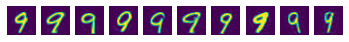

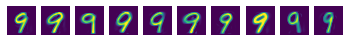

In [21]:
rand_num = np.random.randint(0, X.shape[0])

rand_ints = []
for i in range(10):
	rand_ints.append(np.random.randint(0, X.shape[0]))

# show original images side by side
for i in range(10):
	to_show = X_recon[rand_ints[i],0,:,:].detach().cpu()
	plt.subplot(1,10,i+1)
	plt.imshow(to_show, vmin=0, vmax=1)
	plt.axis('off')

plt.show()
# show original images side by side
for i in range(10):
	to_show = X_hat[rand_ints[i],0,:,:].detach().cpu()
	plt.subplot(1,10,i+1)
	plt.imshow(to_show, vmin=0, vmax=1)
	plt.axis('off')

plt.show()
# print(rand_num)
# # print(X_hat.shape)
# to_show = X_recon[rand_num,0,:,:].detach().cpu()
# to_show2 = X_hat[rand_num,0,:,:].detach().cpu()
# plt.imshow(to_show, vmin=0, vmax=1)
# plt.show()
# plt.imshow(to_show2, vmin=0, vmax=1)
# plt.show()

1985


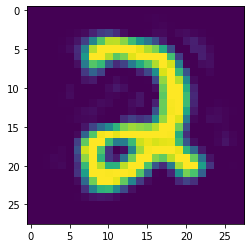

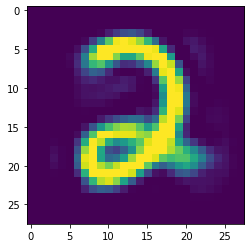

In [27]:
rand_num = np.random.randint(0, X.shape[0])
rand_num = 1985
print(rand_num)
# print(X_hat.shape)
to_show = X_recon[rand_num,0,:,:].cpu()
to_show2 = X_hat[rand_num,0,:,:].cpu()
plt.imshow(to_show, vmin=0, vmax=1)
plt.show()
plt.imshow(to_show2, vmin=0, vmax=1)
plt.show()

In [153]:
print(X_recon.shape)

torch.Size([5958, 1, 28, 28])


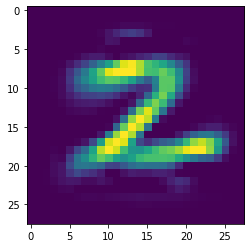

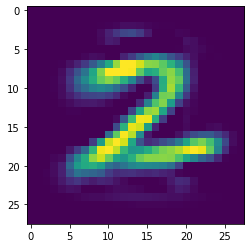

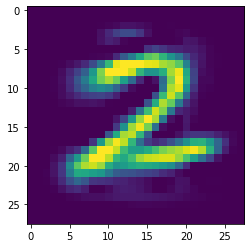

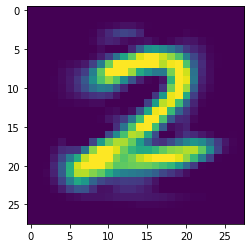

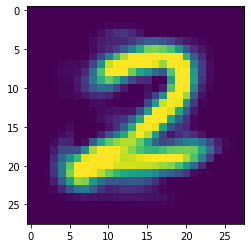

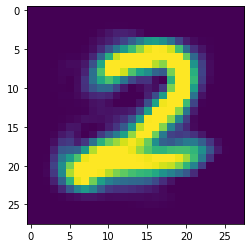

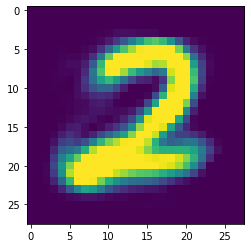

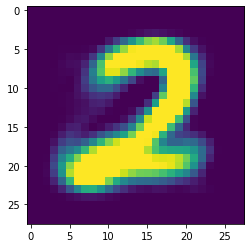

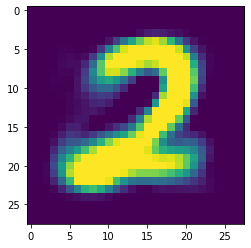

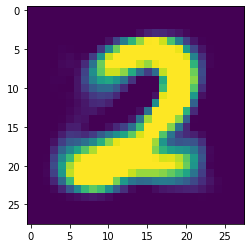

In [103]:
comp_num = 1
for i in range(10):

	# Z_center = Z.mean(dim=0, keepdim=True)
	Z_center = Z[[10],:]
	offset_dir = Vt[comp_num,:].reshape(1,-1)
	offset = 0.1*S[comp_num]*i / 10

	Z_offset = Z_center + offset*offset_dir
	# reconstruct
	X_hat2 = g(Z_offset)

	X_hat2 = X_hat2 * X_norm
	X_hat2 = X_hat2@V_X[:,:num_nonzero].T + X_mean

	# reshape to shape of X_data, but with only 1 datapoint


	X_hat_real = X_hat2[:,:X_f.shape[2]*X_f.shape[3]].reshape(1, X_f.shape[1], X_f.shape[2], X_f.shape[3])
	X_hat_imag = X_hat2[:,X_f.shape[2]*X_f.shape[3]:].reshape(1, X_f.shape[1], X_f.shape[2], X_f.shape[3])
	X_hat_f = X_hat_real + 1j*X_hat_imag
	X_hat2 = torch.fft.ifft2(X_hat_f).real


	to_show3 = X_hat2[0,0,:,:].detach().cpu()
	plt.imshow(to_show3, vmin=0, vmax=1)
	plt.show()

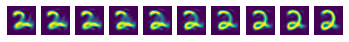

In [61]:
# interpolation
idx1 = np.random.randint(0, X.shape[0])
idx2 = np.random.randint(0, X.shape[0])
idx1 = 5524
idx2 = 1985
Z_1 = Z[[idx1],:]
Z_2 = Z[[idx2],:]

fid = 10
for i in range(fid):

	Z_interp = Z_1 + i/(fid - 1)*(Z_2-Z_1)
	# reconstruct
	X_hat2 = g(Z_interp)

	X_hat2 = X_hat2 * X_norm
	X_hat2 = X_hat2@V_X[:,:num_nonzero].T + X_mean

	# reshape to shape of X_data, but with only 1 datapoint


	X_hat_real = X_hat2[:,:X_f.shape[2]*X_f.shape[3]].reshape(1, X_f.shape[1], X_f.shape[2], X_f.shape[3])
	X_hat_imag = X_hat2[:,X_f.shape[2]*X_f.shape[3]:].reshape(1, X_f.shape[1], X_f.shape[2], X_f.shape[3])
	X_hat_f = X_hat_real + 1j*X_hat_imag
	X_hat2 = torch.fft.ifft2(X_hat_f).real


	to_show3 = X_hat2[0,0,:,:].detach().cpu()
	plt.subplot(1, fid, i+1)
	plt.imshow(to_show3, vmin=0, vmax=1)
	plt.axis('off')
	
plt.show()

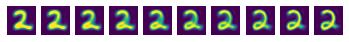

In [49]:
X_hat_1 = g(Z_1)
X_hat_2 = g(Z_2)

X_hat_1 = X_hat_1 * X_norm
X_hat_1 = X_hat_1@V_X[:,:num_nonzero].T + X_mean

# reshape to shape of X_data, but with only 1 datapoint

X_hat_real = X_hat_1[:,:X_f.shape[2]*X_f.shape[3]].reshape(1, X_f.shape[1], X_f.shape[2], X_f.shape[3])
X_hat_imag = X_hat_1[:,X_f.shape[2]*X_f.shape[3]:].reshape(1, X_f.shape[1], X_f.shape[2], X_f.shape[3])
X_hat_f = X_hat_real + 1j*X_hat_imag
X_hat_1 = torch.fft.ifft2(X_hat_f).real

X_hat_2 = X_hat_2 * X_norm
X_hat_2 = X_hat_2@V_X[:,:num_nonzero].T + X_mean

# reshape to shape of X_data, but with only 1 datapoint

X_hat_real = X_hat_2[:,:X_f.shape[2]*X_f.shape[3]].reshape(1, X_f.shape[1], X_f.shape[2], X_f.shape[3])
X_hat_imag = X_hat_2[:,X_f.shape[2]*X_f.shape[3]:].reshape(1, X_f.shape[1], X_f.shape[2], X_f.shape[3])
X_hat_f = X_hat_real + 1j*X_hat_imag
X_hat_2 = torch.fft.ifft2(X_hat_f).real

fid = 10
for i in range(fid):

	X_interp = X_hat_1 + i/(fid - 1)*(X_hat_2-X_hat_1)
	# reconstruct


	to_show3 = X_interp[0,0,:,:].detach().cpu()
	plt.subplot(1, fid, i+1)
	plt.imshow(to_show3, vmin=0, vmax=1)
	plt.axis('off')

plt.show()

In [27]:
num_samples = 20
# Z_center = Z.mean(dim=0, keepdim=True)
rand_sample = torch.randn(num_samples, 11).cuda()
Z_sample = 0.15*rand_sample @ torch.diag(S[:11]).sqrt() @ Vt[:11,:] + torch.mean(Z, dim=0, keepdims=True)

# reconstruct
X_hat2 = g(Z_sample)

X_hat2 = X_hat2 * X_norm
X_hat2 = X_hat2@V_X[:,:num_nonzero].T + X_mean

# reshape to shape of X_data, but with only 1 datapoint


X_hat_real = X_hat2[:,:X_f.shape[2]*X_f.shape[3]].reshape(num_samples, X_f.shape[1], X_f.shape[2], X_f.shape[3])
X_hat_imag = X_hat2[:,X_f.shape[2]*X_f.shape[3]:].reshape(num_samples, X_f.shape[1], X_f.shape[2], X_f.shape[3])
X_hat_f = X_hat_real + 1j*X_hat_imag
X_hat2 = torch.fft.ifft2(X_hat_f).real


for i in range(10):
	to_show3 = X_hat2[i,0,:,:].detach().cpu()
	plt.subplot(1, num_samples, i+1)
	plt.imshow(to_show3, vmin=0, vmax=1)
	plt.axis('off')

plt.show()

for i in range(10,num_samples):
	to_show3 = X_hat2[i,0,:,:].detach().cpu()
	plt.subplot(1, num_samples, i+1)
	plt.imshow(to_show3, vmin=0, vmax=1)
	plt.axis('off')

plt.show()